# Trialing Landslide Activity Filters

## Setup

In [1]:
# run in forrestwilliams/gis:1.02
%matplotlib inline
import rasterio as rio
import geopandas as gpd
from pathlib import Path
from rasterstats import zonal_stats
from skimage import morphology
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [96]:
def read_raster(path,bands=1,crs=False):
    with rio.open(path) as dst:
        array = dst.read(bands)
        profile = dst.profile
        crs_val = dst.crs
        # array = np.moveaxis(array,0,-1)
    
    result = [array, profile]

    if crs:
        result.append(crs_val)

    return result


def write_raster(array,profile,out_path,dtype=rio.uint8):
    # From rasterio docs:
    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rio.Env():
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=dtype,
            count=1,
            compress='lzw')

        with rio.open(out_path, 'w', **profile) as dst:
            dst.write(array.astype(dtype), 1)

    return out_path


def vel_coh_filter(vel_array, coh_array, coh_thresh, n_std=2, min_size=None):
    data = vel_array.copy()

    # mask pixels with velocities less than 2 x velocity std in space
    mean = np.nanmean(vel_array)
    std = np.nanstd(vel_array)
    vel_mask = np.abs(vel_array - mean) > (std * n_std)
    
    # mask pixels with temporal coherence below threshold
    coh_mask = coh_array > coh_thresh
    mask = vel_mask & coh_mask

    # optionally remove small objects (min size in pixels)
    if min_size:
        mask = morphology.remove_small_objects(mask,min_size=min_size)
    
    data[~mask] = np.nan
    
    return (data, mask)


def bekaert_filter(vel_array, std_array, min_size=None):
    data = vel_array.copy()
    
    # mask pixels less than 2 x temporal standard deviation
    mask = np.abs(data - np.nanmean(vel_array)) > (2 * std_array)

    # optionally remove small objects (min size in pixels)
    if min_size:
        mask = morphology.remove_small_objects(mask,min_size=min_size)
    
    data[~mask] = np.nan
    
    return (data, mask)


def add_trial_column(gdf,mask,col_name,update=False):
    
    # if (col_name not in list(gdf.columns)) | update:
    # Get polygons
    zones = list(gdf.geometry)

    # Perform zonal stats within landslide boundary to count number of pixels identified as active
    zs = zonal_stats(zones, mask.astype(float), affine=affine,stats=['count'],nodata=0.0)

    # Change count to binary measure of activity and add to geodataframe
    counts = pd.Series([x['count'] for x in zs])
    test_set[col_name] = (counts > 0).astype(int)

    return gdf


In [3]:
cd ../data/results

/home/micromamba/data/results


## Prep landslide activity test dataset

In [83]:
active_type = 'active_v2'

ls_path = Path('large_landslidesV3.shp')
test_path = Path('test_set.shp')
ls = gpd.read_file(ls_path).to_crs(32760)

test_set = ls.loc[ls[active_type].isin([0,1])].reset_index(drop=True)
test_set = test_set[['Name','area_ha',active_type,'geometry']]
test_set = test_set.rename(columns={'Name':'name',active_type:'active'})
test_set = test_set.loc[test_set.area_ha > 5].reset_index(drop=True)

# test_set.to_file(test_path)
# test_set = gpd.read_file(test_path)
# test_set[['active_v2','area_ha']].groupby('active_v2').median()

In [84]:
test_set[['active','name']].groupby('active').count()

,name
active,
0.0,15
1.0,12


In [85]:
test_set

,name,area_ha,active,geometry
0,144,18.67980,0.0,"POLYGON Z ((404436.980 5603128.108 0.000, 4044..."
1,155,1047.39000,1.0,"POLYGON Z ((400234.051 5598968.261 0.000, 4002..."
2,175,10.94230,0.0,"POLYGON Z ((414683.901 5593917.943 0.000, 4146..."
3,187,13.36990,0.0,"POLYGON Z ((408387.673 5607219.010 0.000, 4083..."
4,191,13.21110,1.0,"POLYGON Z ((398622.839 5611749.535 0.000, 3986..."
5,195,126.04400,0.0,"POLYGON Z ((402793.156 5609683.180 0.000, 4027..."
6,205,68.51900,0.0,"POLYGON Z ((406334.852 5625476.393 0.000, 4063..."
7,227,8.81740,0.0,"POLYGON Z ((389791.645 5612899.916 0.000, 3897..."
8,230,88.42820,1.0,"POLYGON Z ((399065.446 5611947.750 0.000, 3990..."
9,298,10.26800,0.0,"POLYGON Z ((294190.333 5604687.085 0.000, 2941..."


## Trial activity filters

### Load Data

In [9]:
dataset_names = ['velocity_asc','velocity_desc','velocity_up','velocity_ew',
            'std_asc','std_desc',
            'temporalCoherence_asc','temporalCoherence_desc','temporalCoherence_avg']
# dataset_names = ['velocity_desc','temporalCoherence_desc']
years = ['2019','2020','2021']

In [10]:
datasets = {}
for d in dataset_names:
    years_dic = {}
    
    for y in years:
        name = f'{d}_{y}.tif'
        print(f'Reading {name} ...')
        years_dic[y] = read_raster(name)[0]

    datasets[d] = years_dic

print('Done!')

Reading velocity_asc_2019.tif ...
Reading velocity_asc_2020.tif ...
Reading velocity_asc_2021.tif ...
Reading velocity_desc_2019.tif ...
Reading velocity_desc_2020.tif ...
Reading velocity_desc_2021.tif ...
Reading velocity_up_2019.tif ...
Reading velocity_up_2020.tif ...
Reading velocity_up_2021.tif ...
Reading velocity_ew_2019.tif ...
Reading velocity_ew_2020.tif ...
Reading velocity_ew_2021.tif ...
Reading std_asc_2019.tif ...
Reading std_asc_2020.tif ...
Reading std_asc_2021.tif ...
Reading std_desc_2019.tif ...
Reading std_desc_2020.tif ...
Reading std_desc_2021.tif ...
Reading temporalCoherence_asc_2019.tif ...
Reading temporalCoherence_asc_2020.tif ...
Reading temporalCoherence_asc_2021.tif ...
Reading temporalCoherence_desc_2019.tif ...
Reading temporalCoherence_desc_2020.tif ...
Reading temporalCoherence_desc_2021.tif ...
Reading temporalCoherence_avg_2019.tif ...
Reading temporalCoherence_avg_2020.tif ...
Reading temporalCoherence_avg_2021.tif ...
Done!


In [11]:
(200 * 200) / (40*40)

25.0

In [12]:
datasets['velocity_desc']['2019'].shape

(2572, 4782)

In [97]:
profile = read_raster('velocity_ew_2019.tif')[1]
affine = profile['transform']

In [61]:
min_size = 10
coh_thresh = 0.9

## Data exploration

In [101]:
test_set.shape

(27, 10)

In [102]:
test_set[['active','area_ha']].groupby('active').median()

,area_ha
active,
0.0,18.6798
1.0,61.2895


In [104]:
coh = datasets['temporalCoherence_desc']['2019']
vel = datasets['velocity_desc']['2019']

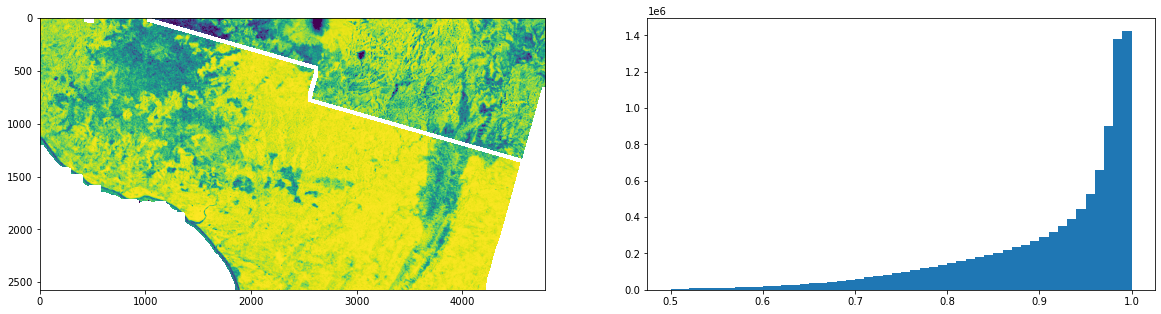

In [105]:
vmin, vmax = (0.5,1)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.imshow(coh,vmin=vmin,vmax=vmax)
h=ax2.hist(coh.flatten(),range=(vmin,vmax),bins=50)

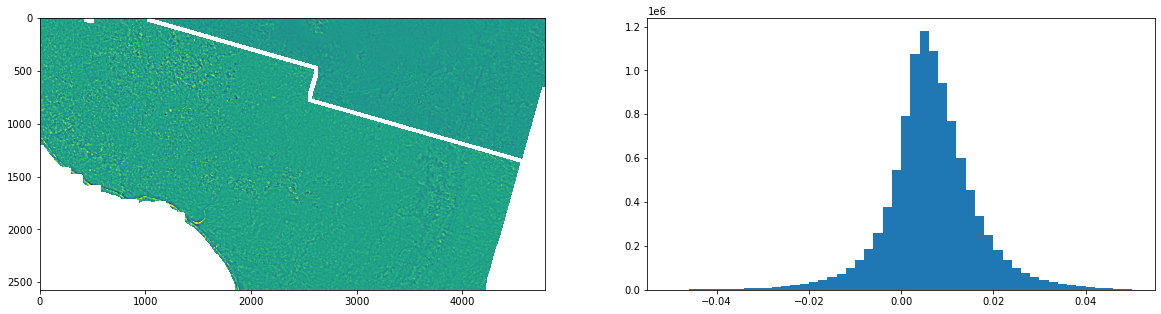

In [106]:
vmin, vmax = (-0.05,0.05)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.imshow(vel,vmin=vmin,vmax=vmax)
h=ax2.hist(vel.flatten(),range=(vmin,vmax),bins=50)

### Bekaert Asc

In [62]:
for y in years:
    _, mask = bekaert_filter(datasets['velocity_asc'][y], datasets['std_asc'][y], min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'bekaert_asc_{y}')

### Bekaert Desc

In [88]:
for y in years:
    _, mask = bekaert_filter(datasets['velocity_desc'][y], datasets['std_desc'][y], min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'bekaert_desc_{y}')

### Vel_coh Desc

In [100]:
for y in years:
    active, mask = vel_coh_filter(datasets['velocity_desc'][y], datasets['temporalCoherence_desc'][y], coh_thresh=coh_thresh, min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'velcoh_desc_{y}')
    
    if y == '2019':
        write_raster(active,profile,'activity_desc_2019.tif',dtype=rio.float64)

### Vel_coh Asc

In [72]:
for y in years:
    _, mask = vel_coh_filter(datasets['velocity_asc'][y], datasets['temporalCoherence_asc'][y], coh_thresh=coh_thresh, min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'velcoh_asc_{y}')

### Vel_coh Up

In [ ]:
for y in years:
    _, mask = vel_coh_filter(datasets['velocity_up'][y], datasets['temporalCoherence_avg'][y], coh_thresh=coh_thresh, min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'velcoh_up_{y}')

### Vel_coh EW

In [65]:
for y in years:
    _, mask = vel_coh_filter(datasets['velocity_ew'][y], datasets['temporalCoherence_avg'][y], coh_thresh=coh_thresh, min_size=min_size)
    test_set = add_trial_column(test_set,mask,f'velcoh_ew_{y}')

### Vel_coh Combined

In [ ]:
for y in years:
    _, mask1 = vel_coh_filter(datasets['velocity_asc'][y], datasets['temporalCoherence_asc'][y], coh_thresh=coh_thresh, min_size=min_size)
    _, mask2 = vel_coh_filter(datasets['velocity_desc'][y], datasets['temporalCoherence_desc'][y], coh_thresh=coh_thresh, min_size=min_size)
    
    mask = mask1 | mask2

    test_set = add_trial_column(test_set,mask,f'velcoh_combo_{y}')

### Vel_coh Projected & Combined

In [ ]:
for y in years:
    _, mask1 = vel_coh_filter(datasets['velocity_up'][y], datasets['temporalCoherence_avg'][y], coh_thresh=coh_thresh, min_size=min_size)
    _, mask2 = vel_coh_filter(datasets['velocity_ew'][y], datasets['temporalCoherence_avg'][y], coh_thresh=coh_thresh, min_size=min_size)
    
    mask = mask1 | mask2

    test_set = add_trial_column(test_set,mask,f'velcoh_proj_{y}')

### Testing

In [ ]:
for y in years:
    # # option 1
    # _, mask1 = vel_coh_filter(datasets['velocity_asc'][y], datasets['temporalCoherence_asc'][y], coh_thresh=0.8, n_std=2, min_size=3)
    # _, mask2 = vel_coh_filter(datasets['velocity_desc'][y], datasets['temporalCoherence_desc'][y], coh_thresh=0.8, n_std=2, min_size=3)
    # mask = mask1 & mask2
    
    # # option 2
    # _, mask = vel_coh_filter(datasets['velocity_desc'][y], datasets['temporalCoherence_desc'][y], coh_thresh=0.9, n_std=2, min_size=6)
    
    # # option 3
    # avg_vel = (datasets['velocity_desc']['2019'] + datasets['velocity_desc']['2020'] + datasets['velocity_desc']['2021']) / 3
    # avg_tc = (datasets['temporalCoherence_desc']['2019'] + datasets['temporalCoherence_desc']['2020'] + datasets['temporalCoherence_desc']['2021']) / 3
    # _, mask = vel_coh_filter(avg_vel, avg_tc, coh_thresh=0.9, n_std=2, min_size=6)
    
    # option 4
    sum_tc = (datasets['temporalCoherence_desc']['2019'] + datasets['temporalCoherence_desc']['2020'] + datasets['temporalCoherence_desc']['2021'])
    weighted_2019 = datasets['velocity_desc']['2019'] * datasets['temporalCoherence_desc']['2019']
    weighted_2020 = datasets['velocity_desc']['2020'] * datasets['temporalCoherence_desc']['2020']
    weighted_2021 = datasets['velocity_desc']['2021'] * datasets['temporalCoherence_desc']['2021']
    avg_vel = (weighted_2019 + weighted_2020 + weighted_2021) / sum_tc
               
    avg_tc = (datasets['temporalCoherence_desc']['2019'] + datasets['temporalCoherence_desc']['2020'] + datasets['temporalCoherence_desc']['2021']) / 3
    _, mask = vel_coh_filter(avg_vel, avg_tc, coh_thresh=0.9, n_std=2, min_size=6)
    

    test_set = add_trial_column(test_set,mask,f'velcoh_test_{y}',update=False)

### Save Results

In [ ]:
# name = 'activity_measures_c90_ms10_std2.geojson'
# test_set.to_file(name)
# gdf = gpd.read_file(name)

## Stats

In [90]:
gdf = test_set.copy()

trials = [x for x in gdf.columns if ('bekaert' in x) | ('velcoh' in x)]

tmp = gdf[['name','active'] + trials]
cols = tmp.columns

# Desired architecture:
# landslide year active type value

df = tmp.melt(id_vars=cols[0:2],value_vars=cols[2:],value_name='prediction')
df[['method','direction','year']] = df.variable.str.split('_',expand=True)
df['type'] = df.method + '_' + df.direction
df['year'] = df.year.astype(int)
df = df.drop(['method','direction','variable'],axis=1)

In [91]:
# df

In [92]:
# from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
cols = ['type','true_neg','true_pos','kappa','acc']
metrics = pd.DataFrame(columns=cols)

for t in df.type.unique():
    sel = df.loc[df.type == t].copy()

    conf = confusion_matrix(sel.active,sel.prediction)
    kappa = cohen_kappa_score(sel.active,sel.prediction)
    acc = accuracy_score(sel.active,sel.prediction)
    
    metrics = metrics.append(dict(zip(cols,[t,conf[0,0],conf[1,1],kappa,acc])),ignore_index=True)

In [93]:
metrics.sort_values('type')

,type,true_neg,true_pos,kappa,acc
0,bekaert_desc,0,36,0.000000,0.444444
1,velcoh_desc,37,22,0.440678,0.728395


In [94]:
# from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
cols = ['type','year','true_neg','true_pos','kappa','acc']
metrics_yearly = pd.DataFrame(columns=cols)

for t,y in product(df.type.unique(),df.year.unique()):
    sel = df.loc[(df.type == t) & (df.year == y)].copy()

    conf = confusion_matrix(sel.active,sel.prediction)
    kappa = cohen_kappa_score(sel.active,sel.prediction)
    acc = accuracy_score(sel.active,sel.prediction)
    
    metrics_yearly = metrics_yearly.append(dict(zip(cols,[t,y,conf[0,0],conf[1,1],kappa,acc])),ignore_index=True)

In [95]:
metrics_yearly.sort_values(['type','year'])

,type,year,true_neg,true_pos,kappa,acc
0,bekaert_desc,2019,0,12,0.000000,0.444444
1,bekaert_desc,2020,0,12,0.000000,0.444444
2,bekaert_desc,2021,0,12,0.000000,0.444444
3,velcoh_desc,2019,15,9,0.769231,0.888889
4,velcoh_desc,2020,11,6,0.237288,0.629630
5,velcoh_desc,2021,11,7,0.319328,0.666667


## Extra

In [ ]:
sub = metrics_yearly[metrics_yearly['type'].str.contains('velcoh')]

In [ ]:
sub.groupby('year').mean()

In [ ]:
sub.groupby('type').mean()

In [80]:
np.nanmean(datasets['temporalCoherence_desc']['2019'])

0.9071554

In [81]:
np.nanmean(datasets['temporalCoherence_desc']['2020'])

0.8962956

In [82]:
np.nanmean(datasets['temporalCoherence_desc']['2021'])

0.92215157